In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.interpolate import interp1d

import os
import json


#plot Options
import matplotlib as mpl
font = {#'family' : 'normal','weight' : 'bold',
        'size'   : 16
        #,'serif':['Helvetica']
        }
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 400

###
####constants
degree = np.pi/180 # convert form rad to degree


In [5]:
degree = np.pi/180
# remember to input values in radians
def beta(theta, l_eff):

    output = np.zeros_like(theta) 
    cond = np.abs(l_eff * np.tan(theta)) < 1
    output[cond] =  np.arccos(l_eff * np.tan(theta[cond]))
    return output


def U(theta, l_eff):
    # Move conditional to beta only
    return (2*beta(theta, l_eff)-np.sin(2*beta(theta, l_eff)))/np.pi

def V(theta, l_eff):
    # Move conditional to beta only
    return np.sin(beta(theta, l_eff))**3

def jd(theta, l_eff):
    return np.cos(theta) * U(theta, l_eff)

def jw(theta, l_eff):
    result = (
    (4/(3*np.pi))*(1-1/(2*l_eff + 1)) * (1/l_eff) 
    * (np.cos(theta)**2 / np.sin(theta)) 
    * (1-V(theta, l_eff))
    + (1/(2*l_eff + 1))*np.cos(theta) * (1-U(theta, l_eff))
    )
    return result

def j(theta, l_eff):
    return jd(theta, l_eff) + jw(theta, l_eff)

<Figure size 2400x1600 with 0 Axes>

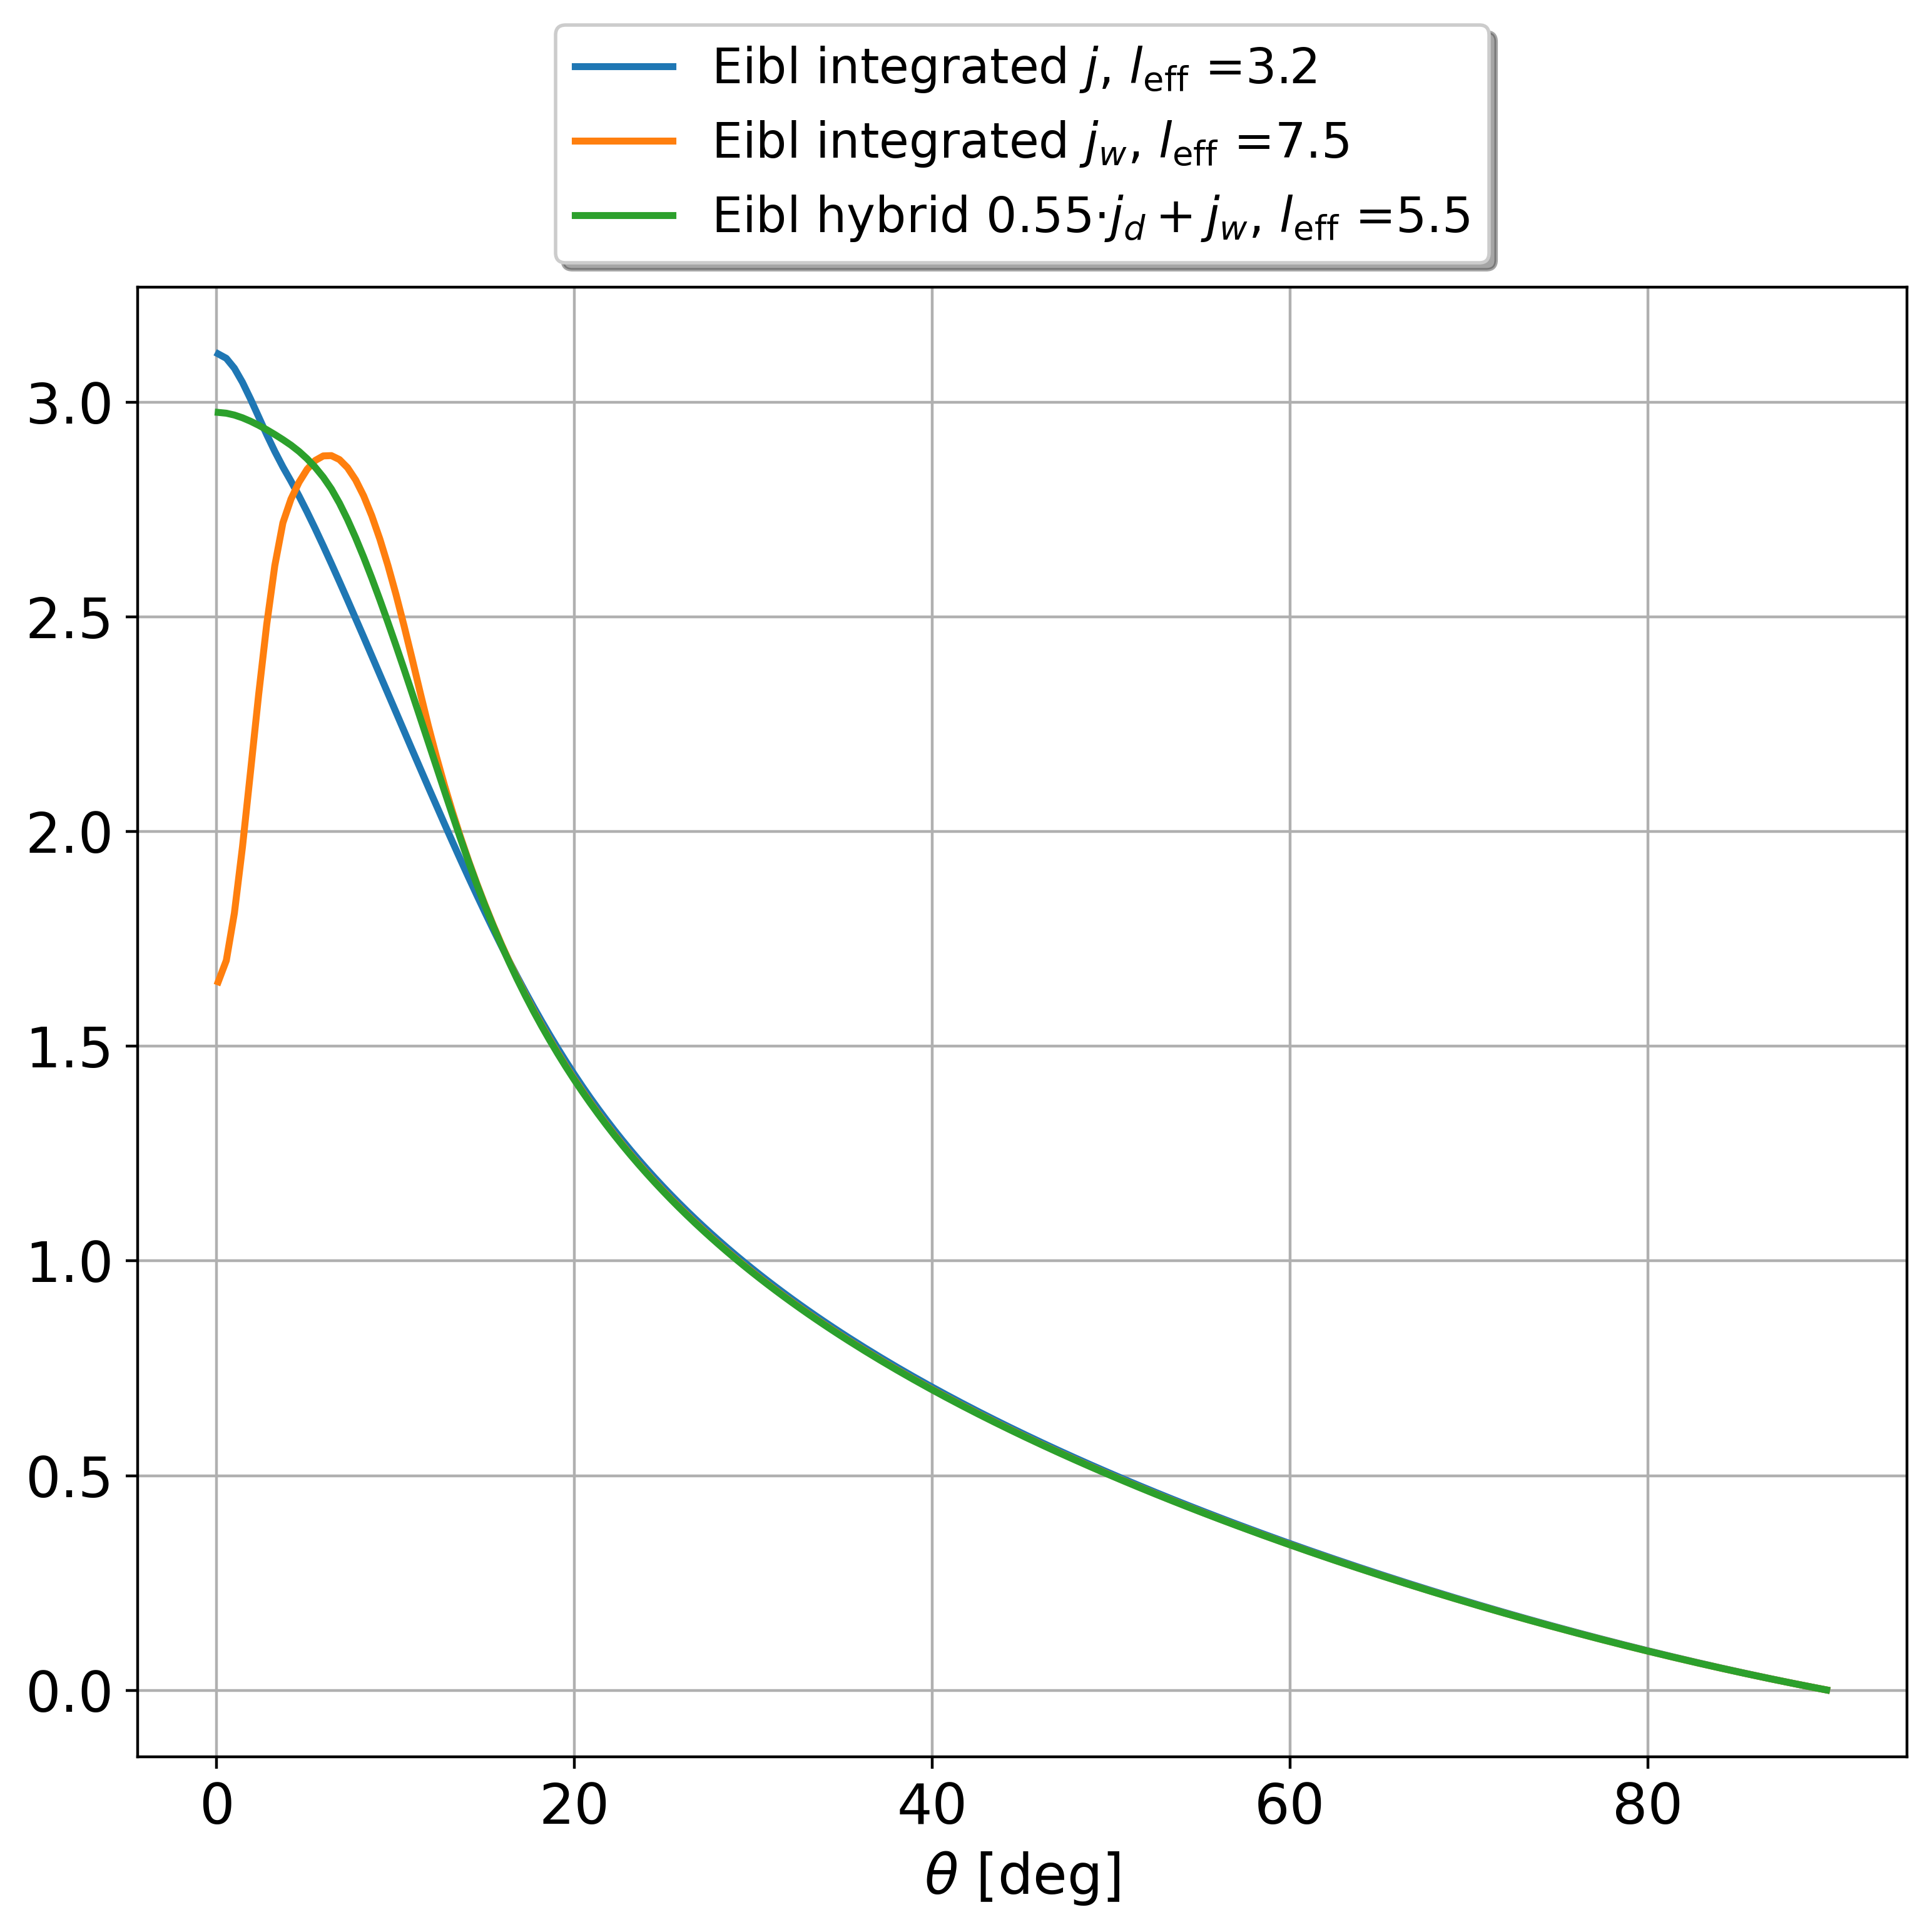

In [6]:
''' attempt to "fit" Eibl Data'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
# l_eff_jw = 7.5 + (400/25)/0.6
l_eff_jw = 5.5
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 200)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff_j) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]
    # Alternate hybrid model
    jd_scale= 0.55
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff_jw) 
                + jw(np.abs(x), l_eff = l_eff_jw))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw_2 = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff_j}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_jw}"),
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")


ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

plt.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


In [85]:
#Eibl data digitized:

data_x = np.array([90, 69.87220447284345, 50.03194888178914, 50.03194888178914, 
     39.968051118210866, 29.90415335463259, 29.97603833865815, 
     29.97603833865815, 27.531948881789138, 24.944089456869012, 
     19.912140575079874, 19.912140575079874, 20.05591054313099, 
     14.880191693290735, 12.579872204472844, 14.880191693290735, 
     9.848242811501597, 9.992012779552716, 7.404153354632588, 
     4.93610369892547, 4.93610369892547, 2.4440894568690097, 
     0.04792039767621805, 0.23961515091478636])
data_y = np.array([0.024193548387096774, 0.07661290322580645, 0.16532258064516128, 
     0.1532258064516129, 0.22580645161290322, 0.29838709677419356, 
     0.35282258064516125, 0.32661290322580644, 0.3286290322580645, 
     0.3790322580645161, 0.4415322580645161, 0.5100806451612903, 
     0.4879032258064516, 0.5866935483870968, 0.6471774193548387, 
     0.719758064516129, 0.8024193548387096, 0.8205645161290323, 
     0.8004032258064516, 0.8645832923150831, 0.8968413568312121,
       0.9129703890892766, 0.9479166461575416, 0.9022177419354839])



<Figure size 2400x1600 with 0 Axes>

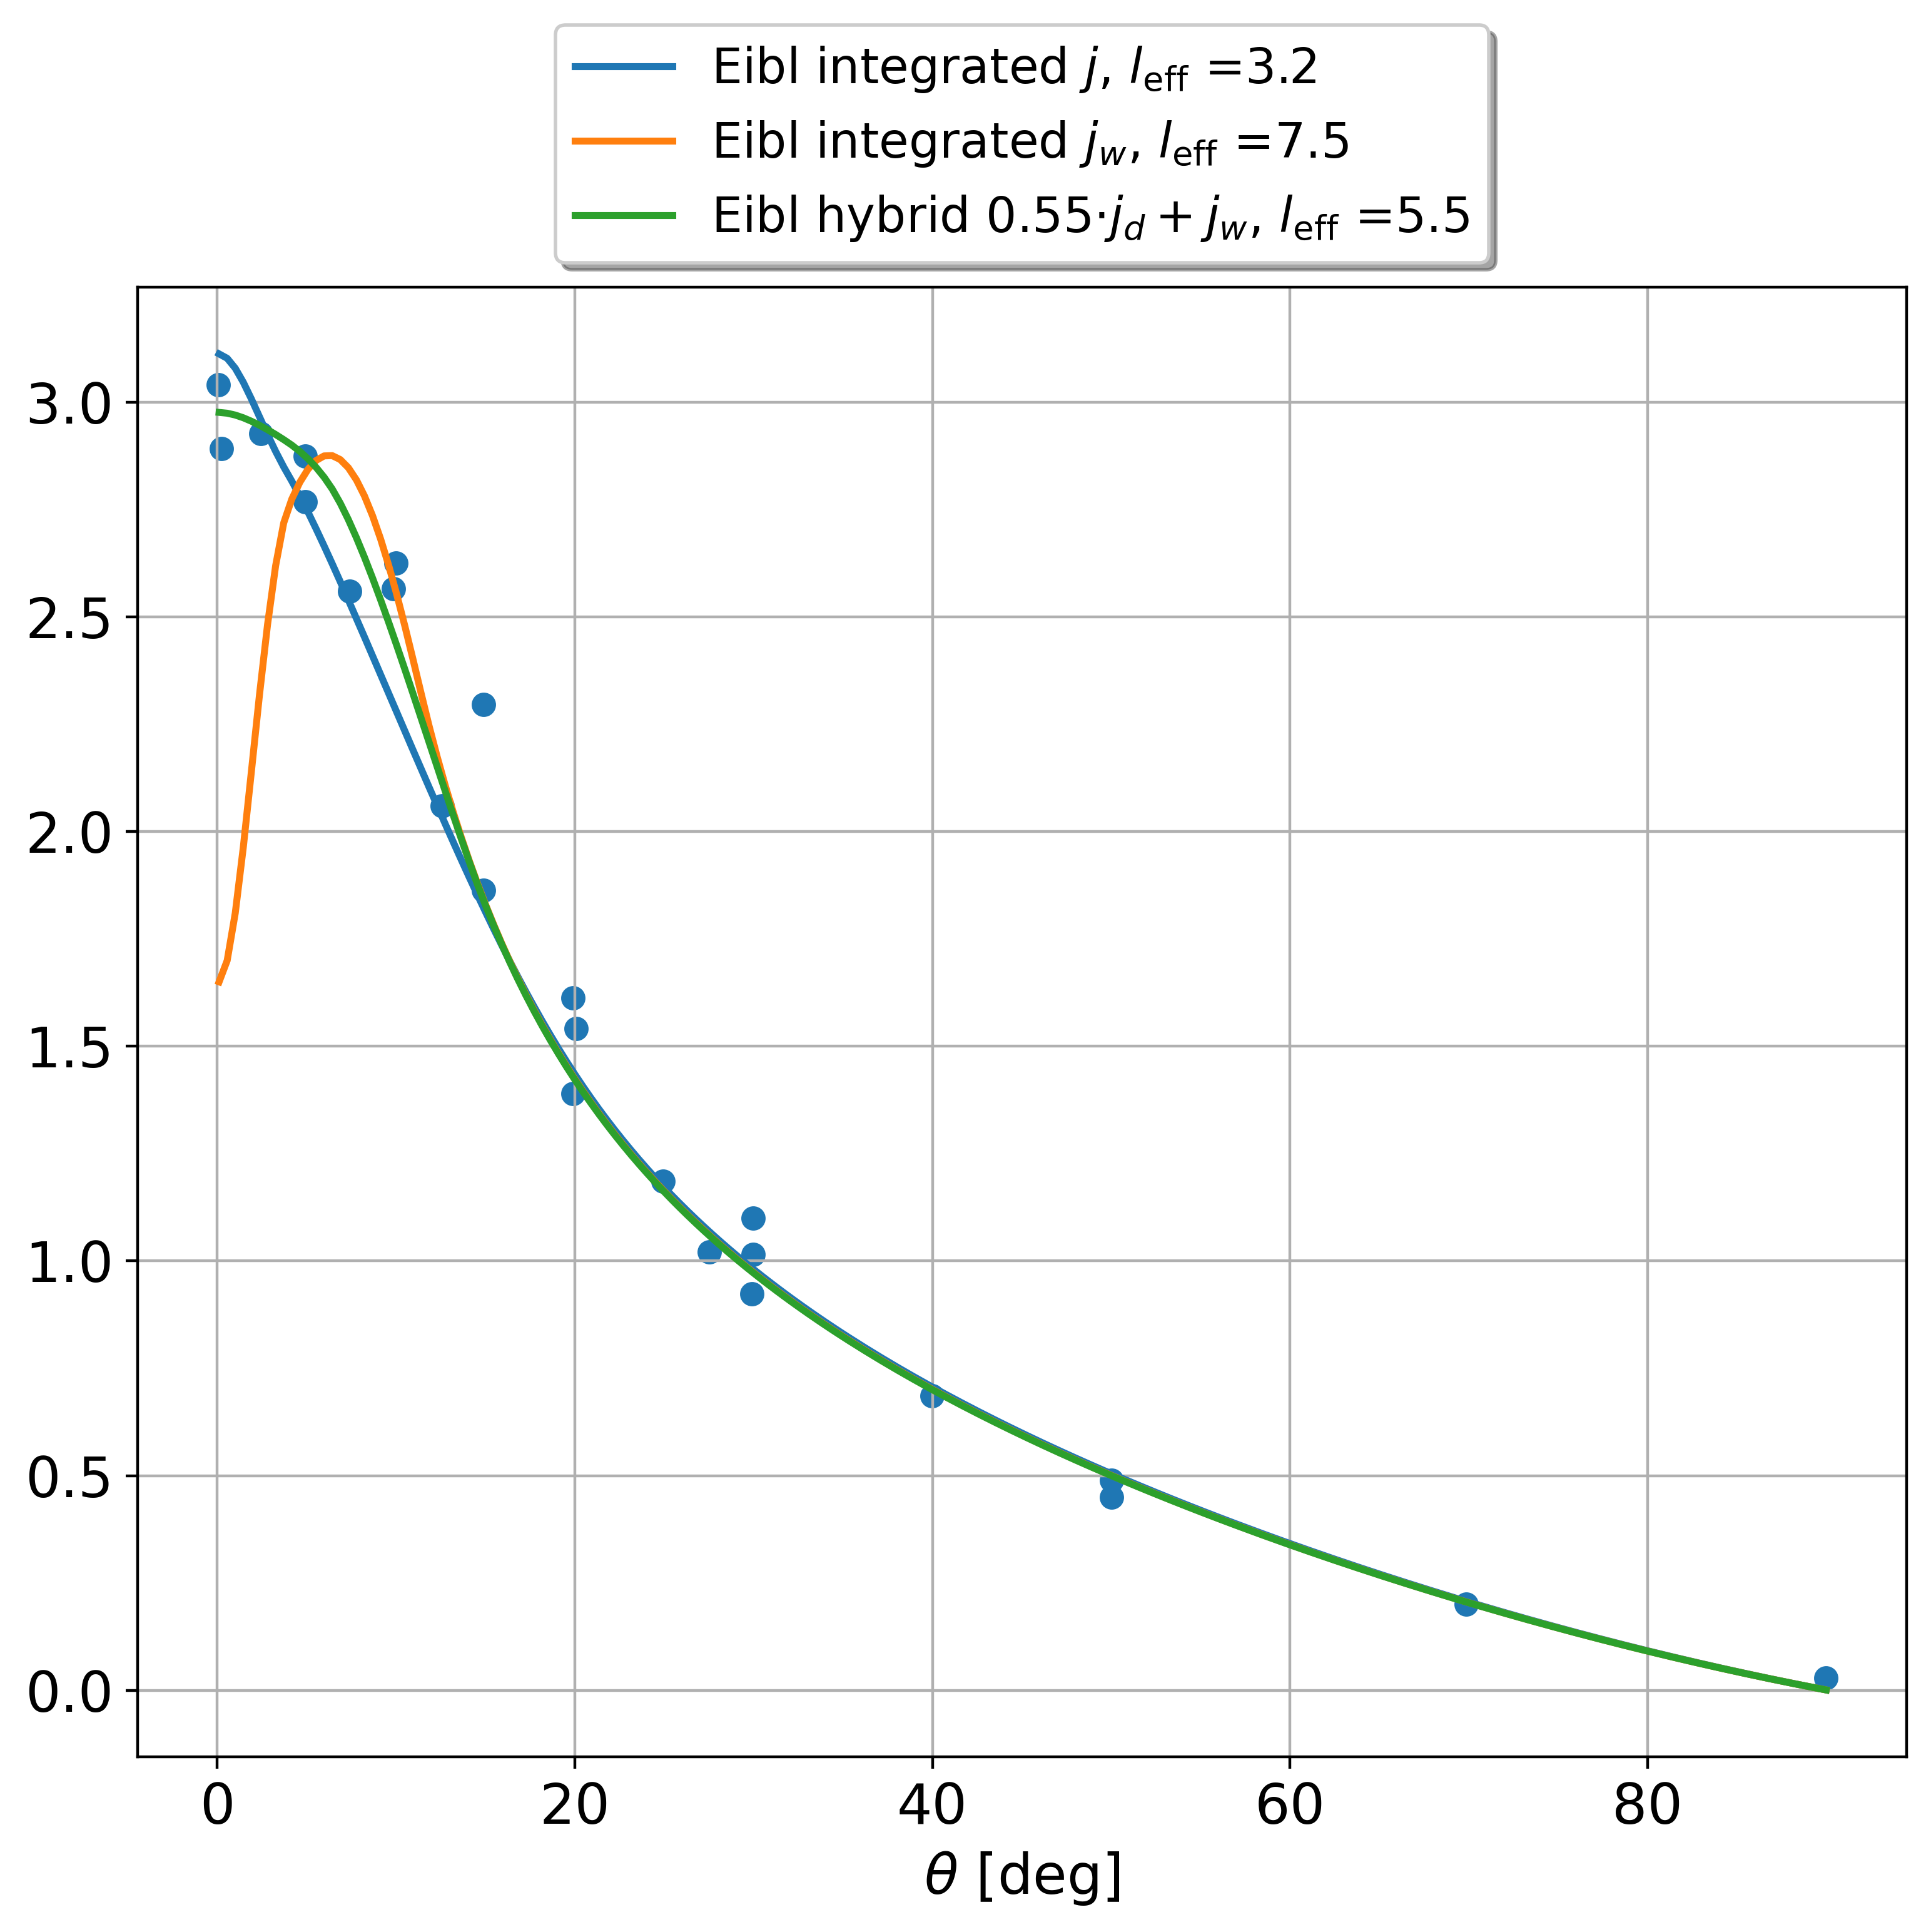

In [111]:
''' attempt to "fit" Eibl Data'''
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,8))
ax1=plt.gca()

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
# l_eff_jw = 7.5 + (400/25)/0.6
l_eff_jw = 5.5
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 200)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff_j) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]
    # Alternate hybrid model
    jd_scale= 0.55
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff_jw) 
                + jw(np.abs(x), l_eff = l_eff_jw))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw_2 = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff_j}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_jw}"),
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")

ax1.scatter(data_x,data_y*(3/0.92)-0.05)

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

plt.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


No handles with labels found to put in legend.


[ 2.82649965e-02 -5.51130927e-03 -1.04397845e-02 -4.98857874e-02
 -1.44237495e-02 -5.18917734e-02  1.28001317e-01  4.25349780e-02
 -3.70466104e-02  2.25085611e-02 -3.80521187e-02  1.85475230e-01
  1.22241835e-01  2.16705089e-02 -5.53752876e-02  4.55576540e-01
  1.10104001e-01  1.86586425e-01 -1.60417313e-01 -1.04876221e-01
  3.13119804e-04 -1.79812290e-02  6.40999152e-02 -8.45649347e-02]


c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:129: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


<Figure size 2400x1600 with 0 Axes>

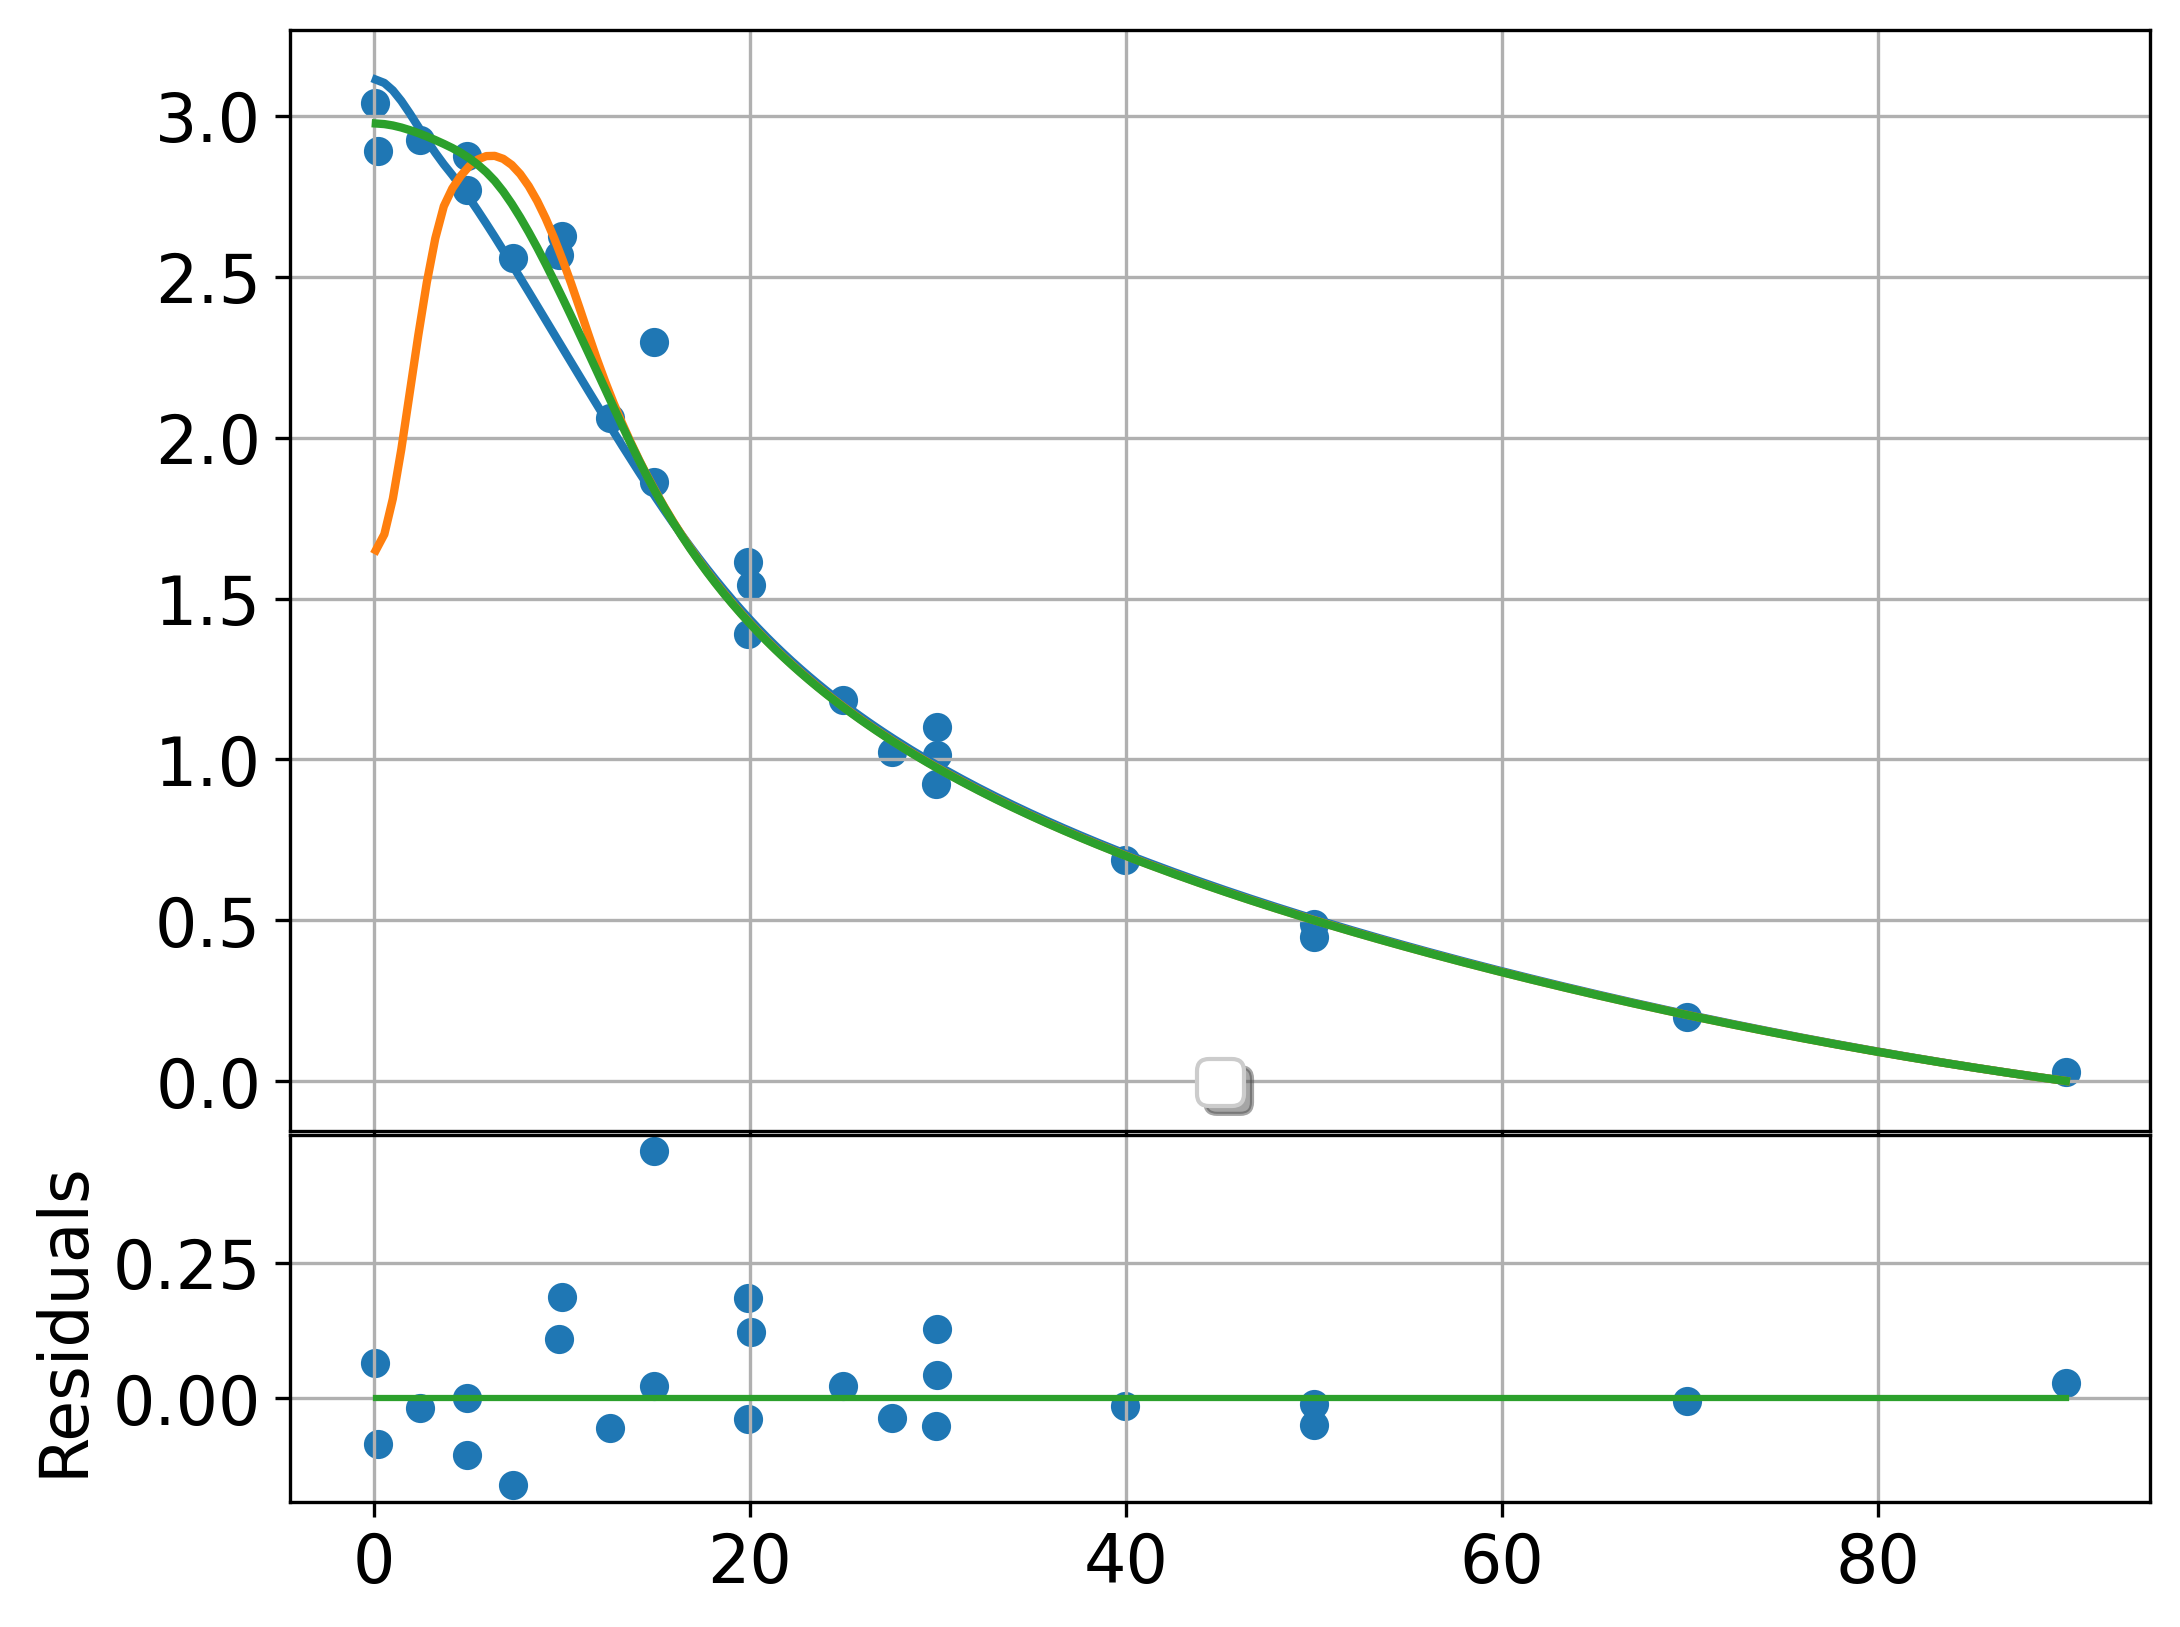

In [120]:
''' attempt to "fit" Eibl Data'''
#With residuals
# Normalize 
from scipy import integrate
# integrant = lambda lw: ((self.beam_profile(theta(lw), l_eff, 
#                                                        theta_max) 
#                                     * np.cos(theta(lw))**3) 
#                                     # Multiply by eta_wire
#                                     * eta(lw)
#                                             )   
# result[i] = integrate.quad(integrant, -10, 10,
#                                 epsabs=1e-1, epsrel=1e-1)[0]

plt.clf()

#l_effs = [0.1,0.32,1.0,3.16,10.0,31.62]
l_effs = [7.5]
# Plot calibration weight uneven electrical heating times "signal" sensitivity
fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
    )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

#angular size of Eibl detector 2.4*10-4 sr ->0.788 deg^2 -> 
# r_rad = 0.4902 *degree
r_rad = 4 *degree
l_eff_j = 3.2
# l_eff_jw = 7.5 + (400/25)/0.6
l_eff_jw = 5.5
for l_eff in l_effs:
    # xs = np.linspace(r_rad/degree + 0.1,90, 1000)
    xs = np.linspace( 0.1,90, 200)
    xs_rad = xs * degree
    # ys = visible_fraction(xs * degree)
    f = lambda x: j(np.abs(x), l_eff = l_eff_j) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # actual integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_j = [
          (f_avg(x)/norm)
          for x in xs_rad]
    
    f = lambda x: jw(np.abs(x), l_eff = l_eff) 
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw = [
          (f_avg(x)/norm)
          for x in xs_rad]
    # Alternate hybrid model
    jd_scale= 0.55
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff_jw) 
                + jw(np.abs(x), l_eff = l_eff_jw))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
    # Trapezoid approximationn for integration
    f_avg = lambda x: (integrate.quad(integrant, x-r_rad, x+r_rad)[0]
            /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0]
                        )
    ys_jw_2 = [
          (f_avg(x)/norm)
          for x in xs_rad]

    ax1.plot(xs,ys_j,
            color = "C0" ,
            label = r"Eibl integrated $j$, $l_{\rm{eff}}$ =" + f"{l_eff_j}",
            lw= 2)
    ax1.plot(xs,ys_jw,
            color = "C1" ,
            label = r"Eibl integrated $j_w$, $l_{\rm{eff}}$ =" + f"{l_eff}",
            lw= 2)
    ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_jw}"),
            lw= 2)
    # ax1.plot(xs,ys,
    #         color = "C1" ,
    #         label = r"Normalized $j_w, l_{\rm{eff}}$ =" + f"{12.79}",
    #         lw= 2)
    # ax1.plot(xs,ys_jd,
    #         color = "C2" ,
    #         label = r"$\dfrac{1.12j(l = 75) - 0.12j_w(l=7.5)}{1.12}}$",
    #         lw= 2)
theta_inner = 0.3385556949116842 # 19.3978 deg 
theta_outer = 0.45799795159722173 # 26.2413 deg
# ax1.axvline(theta_inner / degree, label=r"$\theta_{penumbra} = $"
#         + f"{theta_inner/degree:.2f} [deg]", 
#         color = "gray", alpha = 1, ls = "--")
# ax1.axvline(theta_outer / degree, label=r"$\theta_{umbra} = $"
#         + f"{theta_outer/degree:.2f} [deg]", 
#         color = "k", alpha = 1, ls = "--")

ax1.scatter(data_x,data_y*(3/0.92)-0.05)

#residual subplot:
res_ys = ((data_y*(3/0.92)-0.05) 
            - np.array([(f_avg(x*degree)/norm) for x in data_x] ))
print(res_ys)
ax2.scatter(data_x,res_ys)
#Plot Fit
ax2.plot(xs, [0.0 for x in xs] , 'C2',
    #  label=(('''fit: m={:5.4f} $\pm$ {:2.1e} [Ohm/µW ],
    #  R_0={:5.3f} $\pm$ {:2.1e} [Ohm]'''.format(
    #      popt[0], np.sqrt(pcov[0,0]), popt[1], np.sqrt(pcov[1,1])) 
    #           ))
            )
ax2.set_ylabel(r"Residuals")

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")
ax1.grid(True)

plt.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)


## Fit function

In [164]:


# Alternate hybrid model (VEEEERY Slow)
# def f_fit(x,l_eff, jd_scale,A):
#     r_rad = 4 *degree
#     f = lambda x, l_eff, jd_scale: (jd_scale*jd(np.abs(x), l_eff =l_eff) 
#             + jw(np.abs(x), l_eff = l_eff))
#     integrant = lambda x:f(x,l_eff, jd_scale)*np.sin(np.abs(x))
#     norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
#     # Trapezoid approximationn for integration
#     f_avg = lambda x: (
#         integrate.quad(integrant, x-r_rad, x+r_rad)[0]
#         /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0])
#     return A*f_avg(x, l_eff, jd_scale)/norm

def f_fit(xs,l_eff, jd_scale,A):
    r_rad = 4 *degree
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff) 
                + jw(np.abs(x), l_eff = l_eff))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]

    f_avg = lambda x: (
        integrate.quad(integrant, x-r_rad, x+r_rad)[0]
        /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0])
        
    x_space = xs
    result = np.zeros_like(x_space)
    for i,x in enumerate(x_space): 
        result[i] = f_avg(x)


        
    res = result * A/norm
    return res

#initiate parameters
l_eff_0 = 5.5
jd_scale_0 = 0.55
a0 = (0.92/3)
# a0 = 3
# Use errors as absolute to get proper error estimation
# popt_abs, pcov_abs = curve_fit(f_fit, x, y,
#                     #sigma = 1,
#                     absolute_sigma= False,
#                     p0 = [l_eff_0,jd_scale_0, a0], 
#                     )

popt_abs, pcov = curve_fit(f_fit, data_x*degree, data_y,
                               #sigma = [0.02 for x in data_x],
                               absolute_sigma= False,
                               p0 = [l_eff_0,jd_scale_0,a0], 
                               bounds=([2,   0, 0.02],
                                    [20,    1, 10])
                               )
# popt_abs, pcov_abs = curve_fit(lambda x,c: x+c, x, y)
######
popt_abs, pcov

# Fails because the integraton is not Array capable -> Fix
# See P_innt_fast_array for exammple

(array([4.53452676, 0.6171526 , 0.33501171]),
 array([[ 1.92531268e-01, -2.78666414e-02, -1.64778440e-03],
        [-2.78666414e-02,  4.65134953e-03,  1.37395110e-04],
        [-1.64778440e-03,  1.37395110e-04,  4.59846025e-05]]))

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:50: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


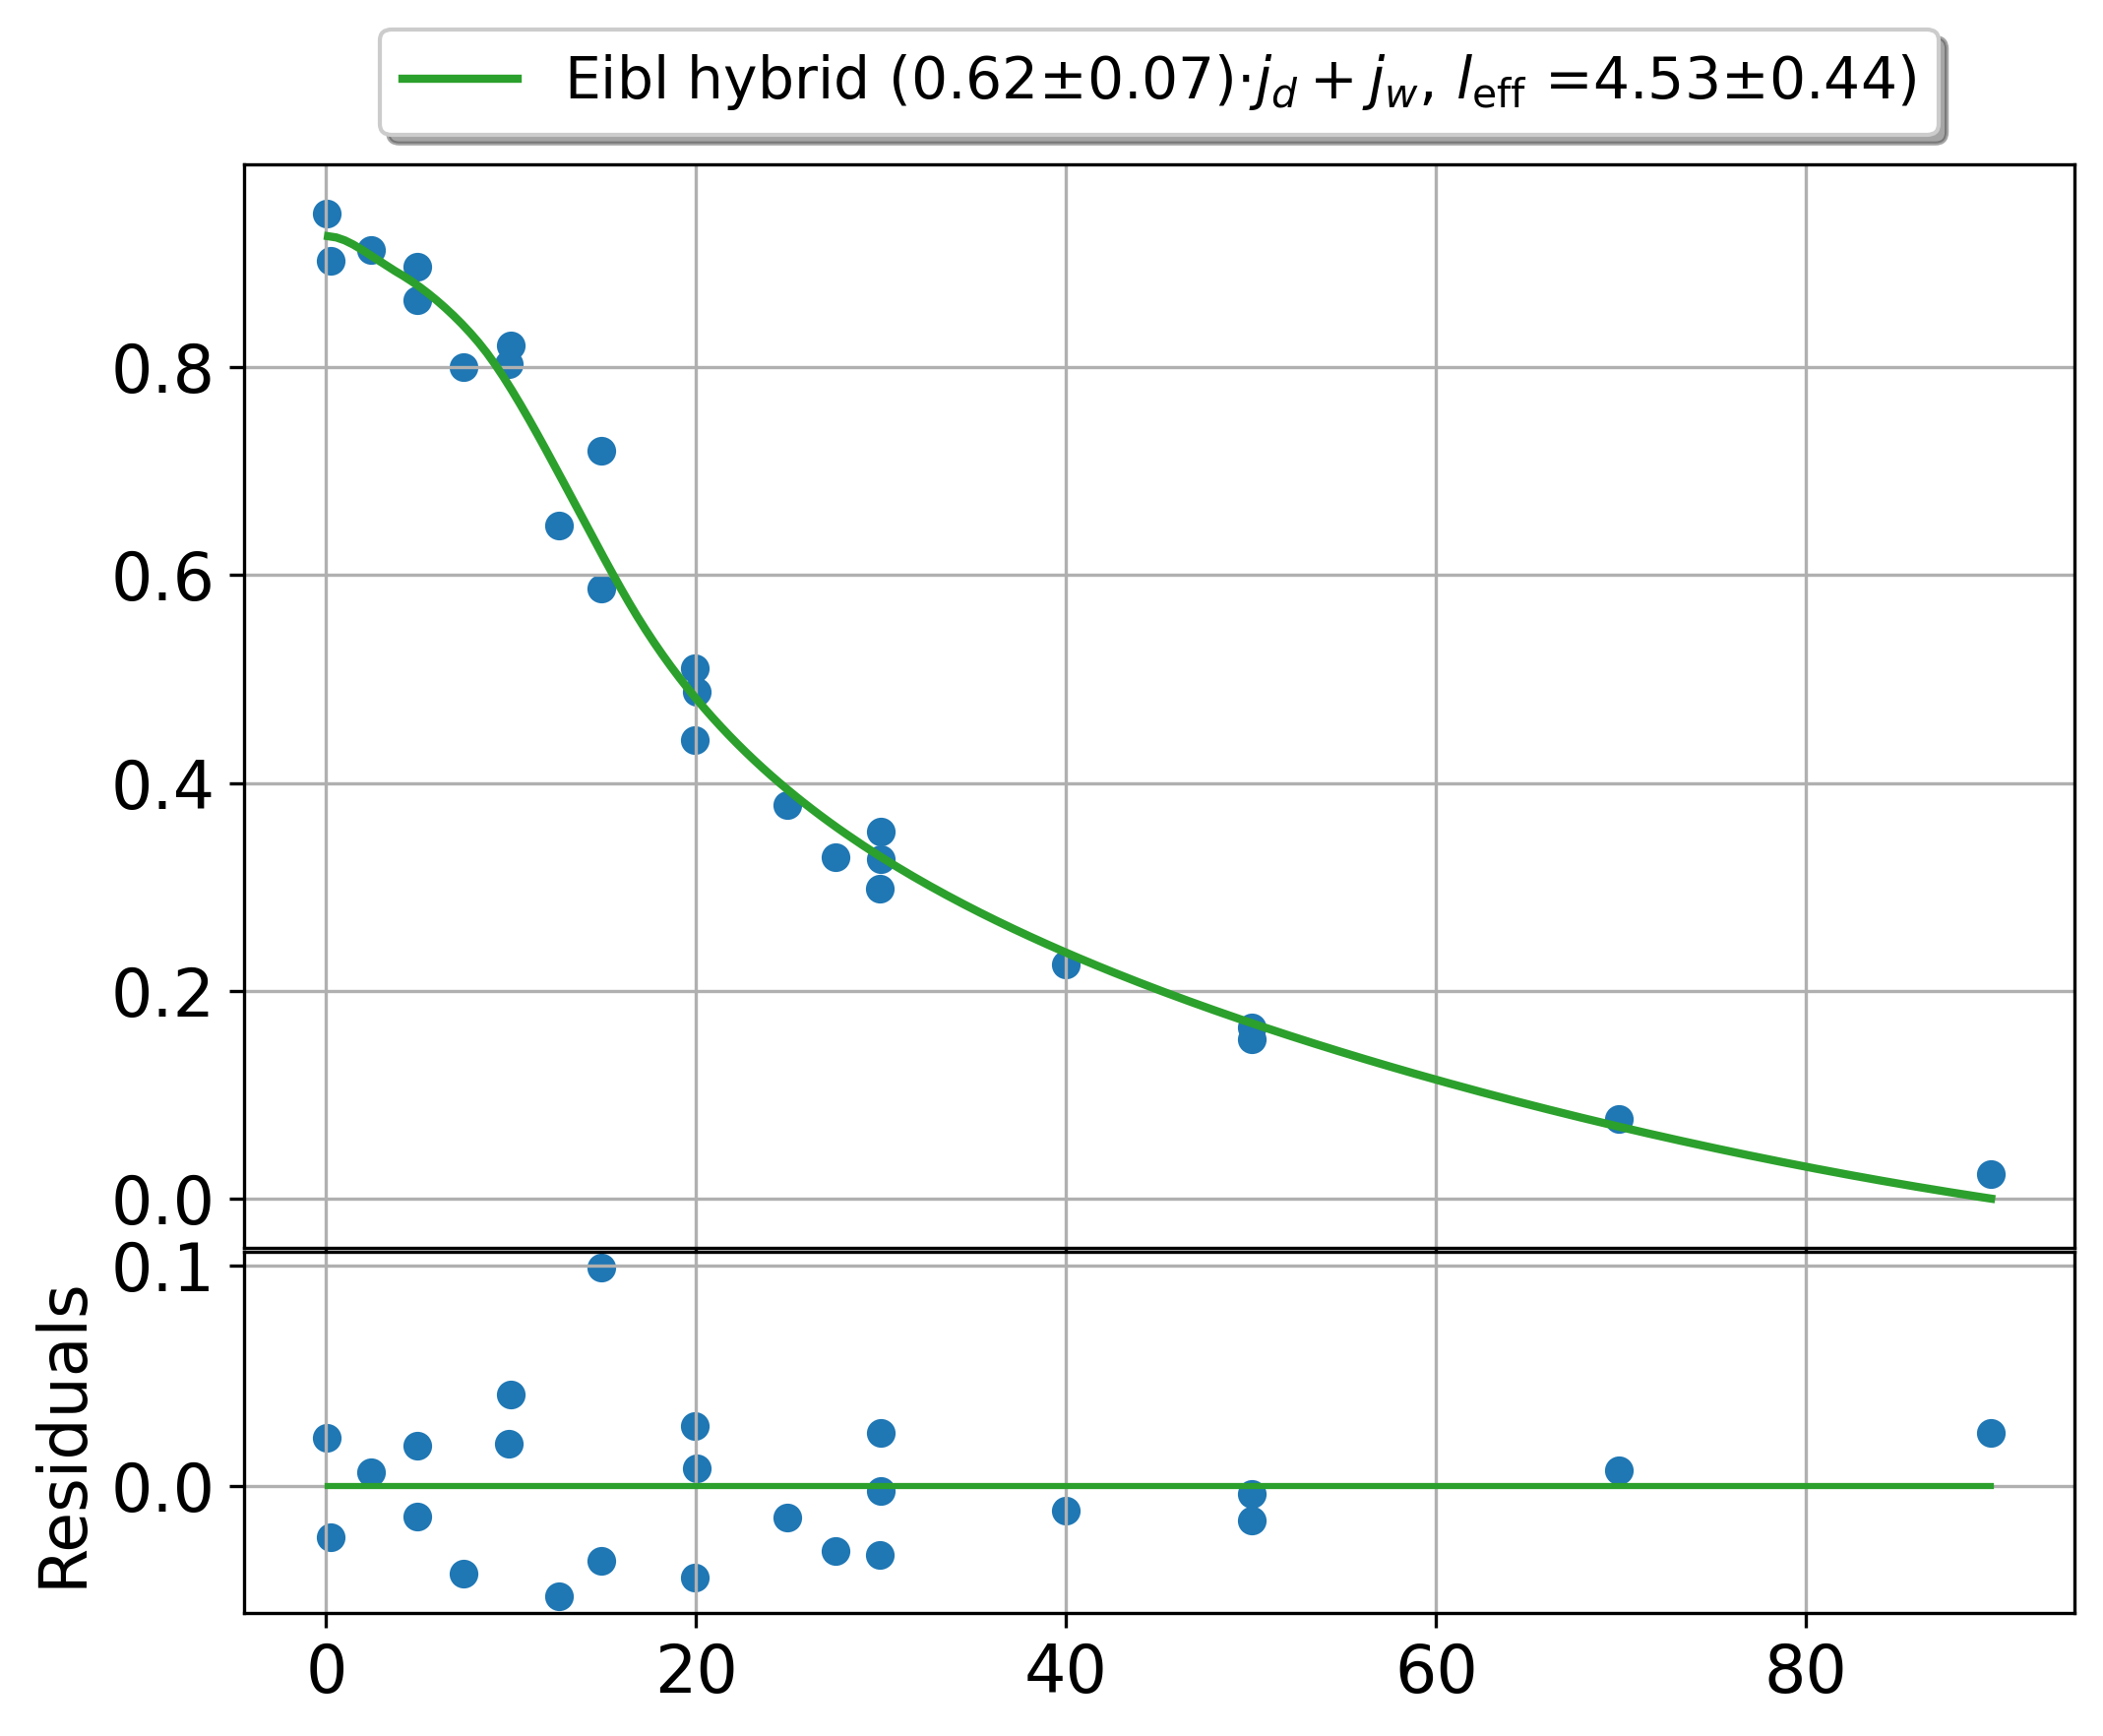

In [165]:
fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
    )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xs = np.linspace( 0.1,90, 200)
xs_rad = xs * degree
ys_jw_2 = f_fit(xs_rad,*popt_abs)
#print(ys_jw_2)
l_eff_jw, jd_scale, A = popt_abs

ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"({jd_scale:.2f}" + r"$\pm$" 
                     +f"{np.sqrt(pcov[1,1]):.2f})"
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" 
                     + f"{l_eff_jw:.2f}"
                     + r"$\pm$" 
                     +f"{np.sqrt(pcov[0,0]):.2f})"),
            lw= 2)

ax1.scatter(data_x,data_y)

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

#residual subplot:
res_ys = ((data_y - f_fit(data_x*degree, *popt_abs) ))
ax2.scatter(data_x,res_ys,
            label="residuals")
#Plot Fit
ax2.plot(xs, [0.0 for x in xs] , 'C2',
            )

ax2.set_ylabel(r"Residuals")

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax1.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


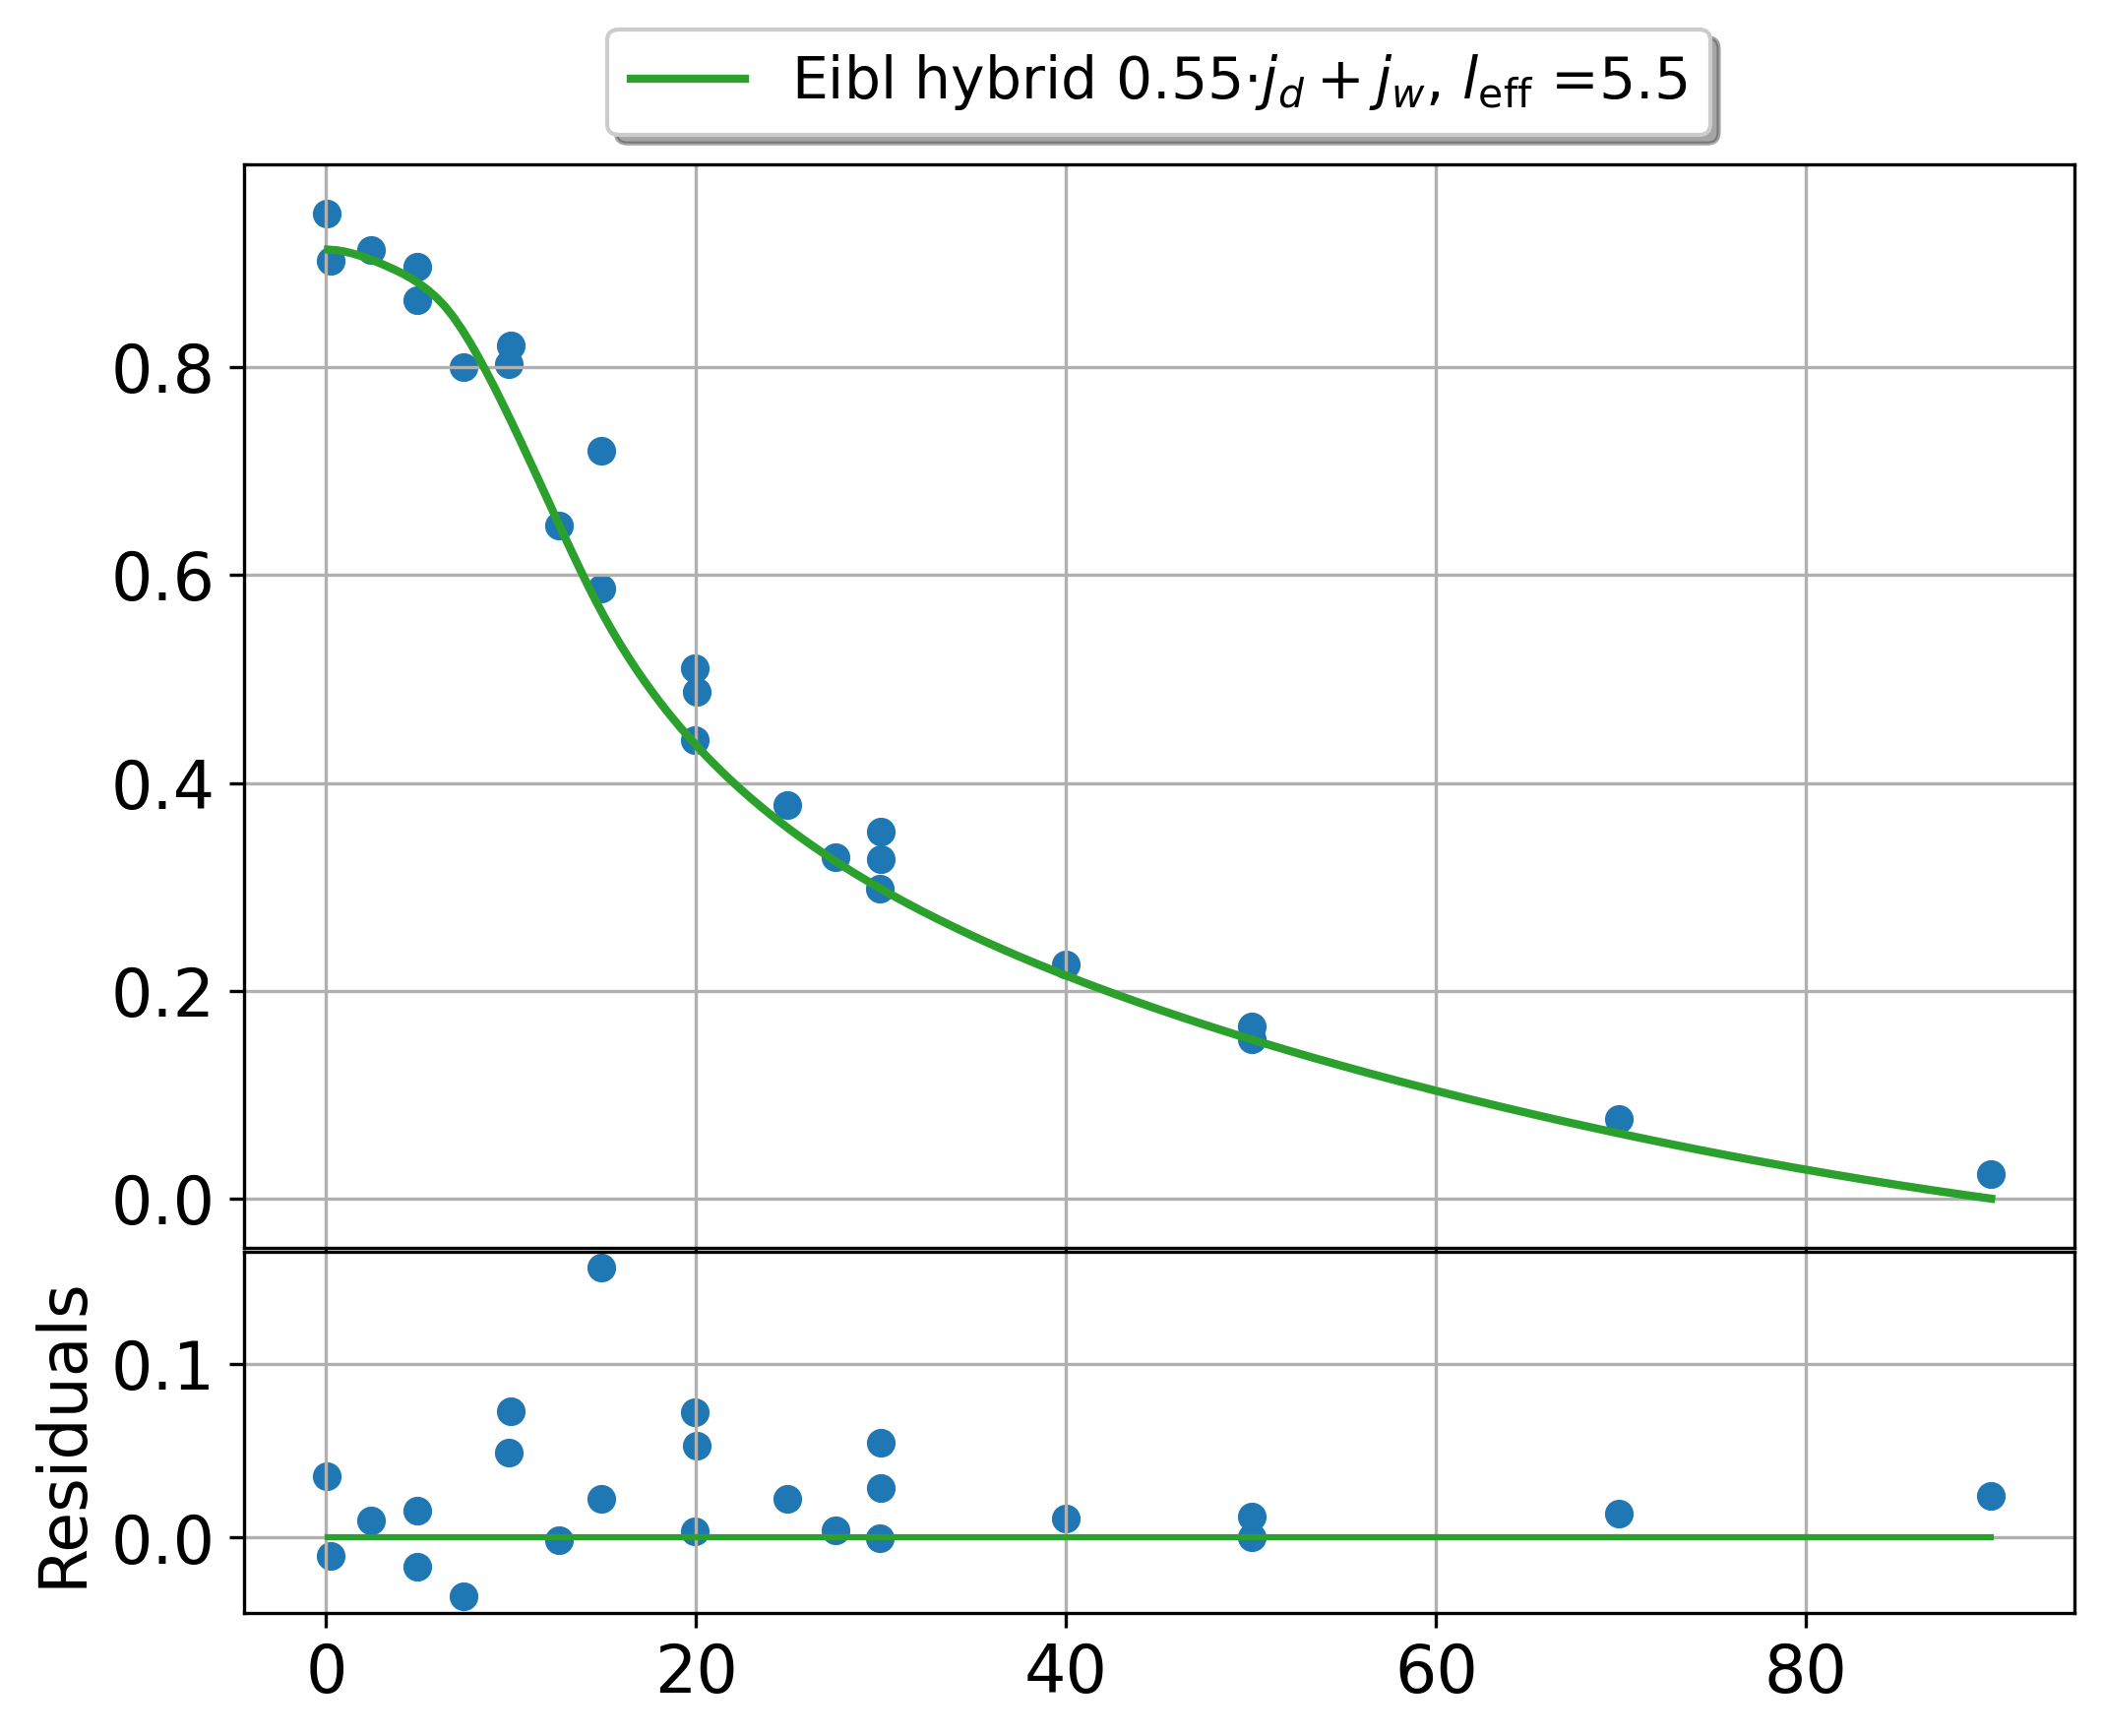

In [161]:
fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
    )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xs = np.linspace( 0.1,90, 200)
xs_rad = xs * degree
ys_jw_2 = f_fit(xs_rad,*[l_eff_0,jd_scale_0,a0])

ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale_0}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_0}"),
            lw= 2)

ax1.scatter(data_x,data_y)

#residual subplot:
res_ys = ((data_y - f_fit(data_x*degree,*[l_eff_0,jd_scale_0,a0]) ))
ax2.scatter(data_x,res_ys,
            label="residuals")
#Plot Fit
ax2.plot(xs, [0.0 for x in xs] , 'C2',
            )

ax2.set_ylabel(r"Residuals")

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax1.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


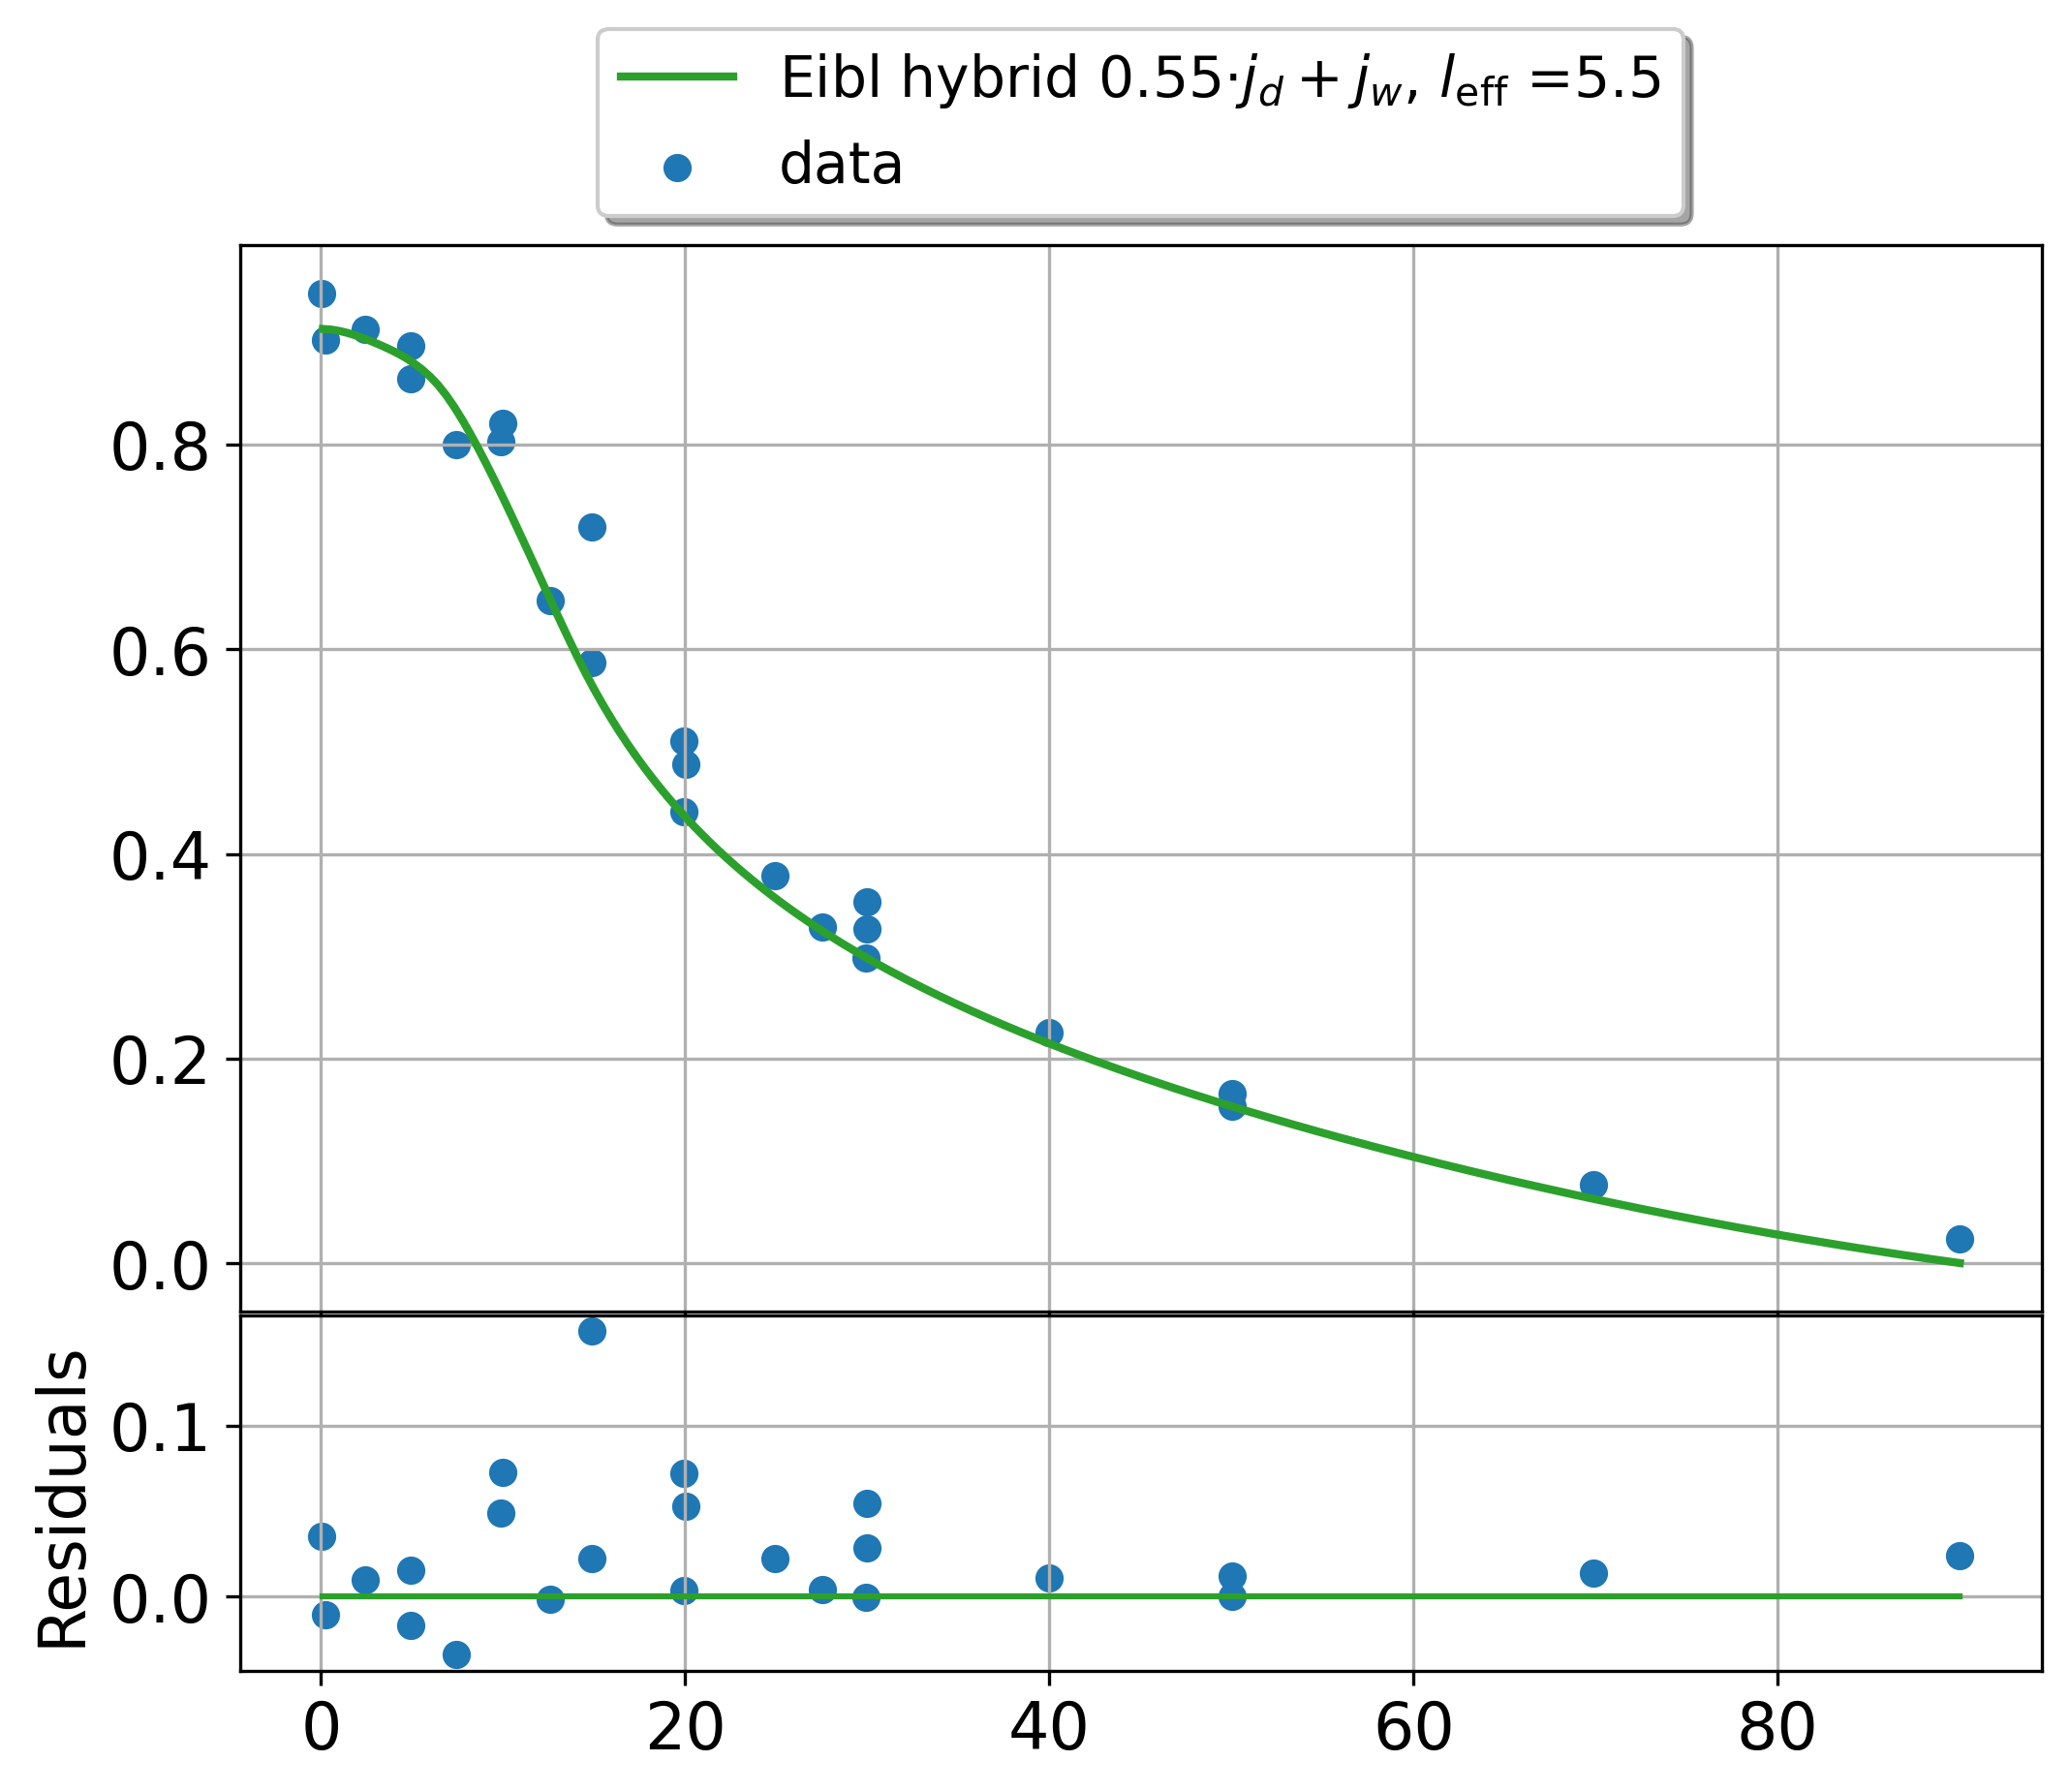

In [160]:
fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
    )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xs = np.linspace( 0.1,90, 200)
xs_rad = xs * degree
ys_jw_2 = f_fit(xs_rad,*[l_eff_0,jd_scale_0,a0])

ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"{jd_scale_0}" 
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" + f"{l_eff_0}"),
            lw= 2)

ax1.scatter(data_x,data_y, label = "data")
#residual subplot:
res_ys = ((data_y - f_fit(data_x*degree,*[l_eff_0,jd_scale_0,a0]) ))
# print(res_ys)
ax2.scatter(data_x,res_ys,
            label="residuals")
#Plot Fit
ax2.plot(xs, [0.0 for x in xs] , 'C2',
    #  label=(('''fit: m={:5.4f} $\pm$ {:2.1e} [Ohm/µW ],
    #  R_0={:5.3f} $\pm$ {:2.1e} [Ohm]'''.format(
    #      popt[0], np.sqrt(pcov[0,0]), popt[1], np.sqrt(pcov[1,1])) 
    #           ))
            )
ax2.set_ylabel(r"Residuals")

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax1.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
plt.tight_layout()
plt.grid(True)

## Fit with the paper implied detector size

In [166]:
r_rad_eibl=0.4902 *degree

# Alternate hybrid model (VEEEERY Slow)
# def f_fit(x,l_eff, jd_scale,A):
#     r_rad = 4 *degree
#     f = lambda x, l_eff, jd_scale: (jd_scale*jd(np.abs(x), l_eff =l_eff) 
#             + jw(np.abs(x), l_eff = l_eff))
#     integrant = lambda x:f(x,l_eff, jd_scale)*np.sin(np.abs(x))
#     norm = 2*integrate.quad(integrant, 0, 90*degree)[0]
#     # Trapezoid approximationn for integration
#     f_avg = lambda x: (
#         integrate.quad(integrant, x-r_rad, x+r_rad)[0]
#         /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0])
#     return A*f_avg(x, l_eff, jd_scale)/norm

def f_fit(xs,l_eff, jd_scale,A):
    r_rad = r_rad_eibl
    f = lambda x: (jd_scale*jd(np.abs(x), l_eff =l_eff) 
                + jw(np.abs(x), l_eff = l_eff))
    integrant = lambda x:f(x)*np.sin(np.abs(x))
    norm = 2*integrate.quad(integrant, 0, 90*degree)[0]

    f_avg = lambda x: (
        integrate.quad(integrant, x-r_rad, x+r_rad)[0]
        /integrate.quad(lambda x: np.sin(np.abs(x)), x-r_rad, x+r_rad)[0])
        
    x_space = xs
    result = np.zeros_like(x_space)
    for i,x in enumerate(x_space): 
        result[i] = f_avg(x)


        
    res = result * A/norm
    return res

#initiate parameters
l_eff_0 = 5.5
jd_scale_0 = 0.55
a0 = (0.92/3)
# a0 = 3
# Use errors as absolute to get proper error estimation
# popt_abs, pcov_abs = curve_fit(f_fit, x, y,
#                     #sigma = 1,
#                     absolute_sigma= False,
#                     p0 = [l_eff_0,jd_scale_0, a0], 
#                     )

popt_abs, pcov = curve_fit(f_fit, data_x*degree, data_y,
                               #sigma = [0.02 for x in data_x],
                               absolute_sigma= False,
                               p0 = [l_eff_0,jd_scale_0,a0], 
                               bounds=([2,   0, 0.02],
                                    [20,    1, 10])
                               )
# popt_abs, pcov_abs = curve_fit(lambda x,c: x+c, x, y)
######
popt_abs, pcov

# Fails because the integraton is not Array capable -> Fix
# See P_innt_fast_array for exammple

(array([4.48083787, 0.61516068, 0.330559  ]),
 array([[ 9.30932351e-02, -1.08884041e-02, -1.04597106e-03],
        [-1.08884041e-02,  1.65538696e-03,  4.56936782e-05],
        [-1.04597106e-03,  4.56936782e-05,  4.25283063e-05]]))

([<matplotlib.lines.Line2D object at 0x000002046F5B5048>], ['Eibl hybrid (0.62$\\pm$0.04)$\\cdot j_d + j_w$, $l_{\\rm{eff}}$ =4.48$\\pm$0.31)'])


c:\Users\Christian\Anaconda3\lib\site-packages\ipykernel_launcher.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


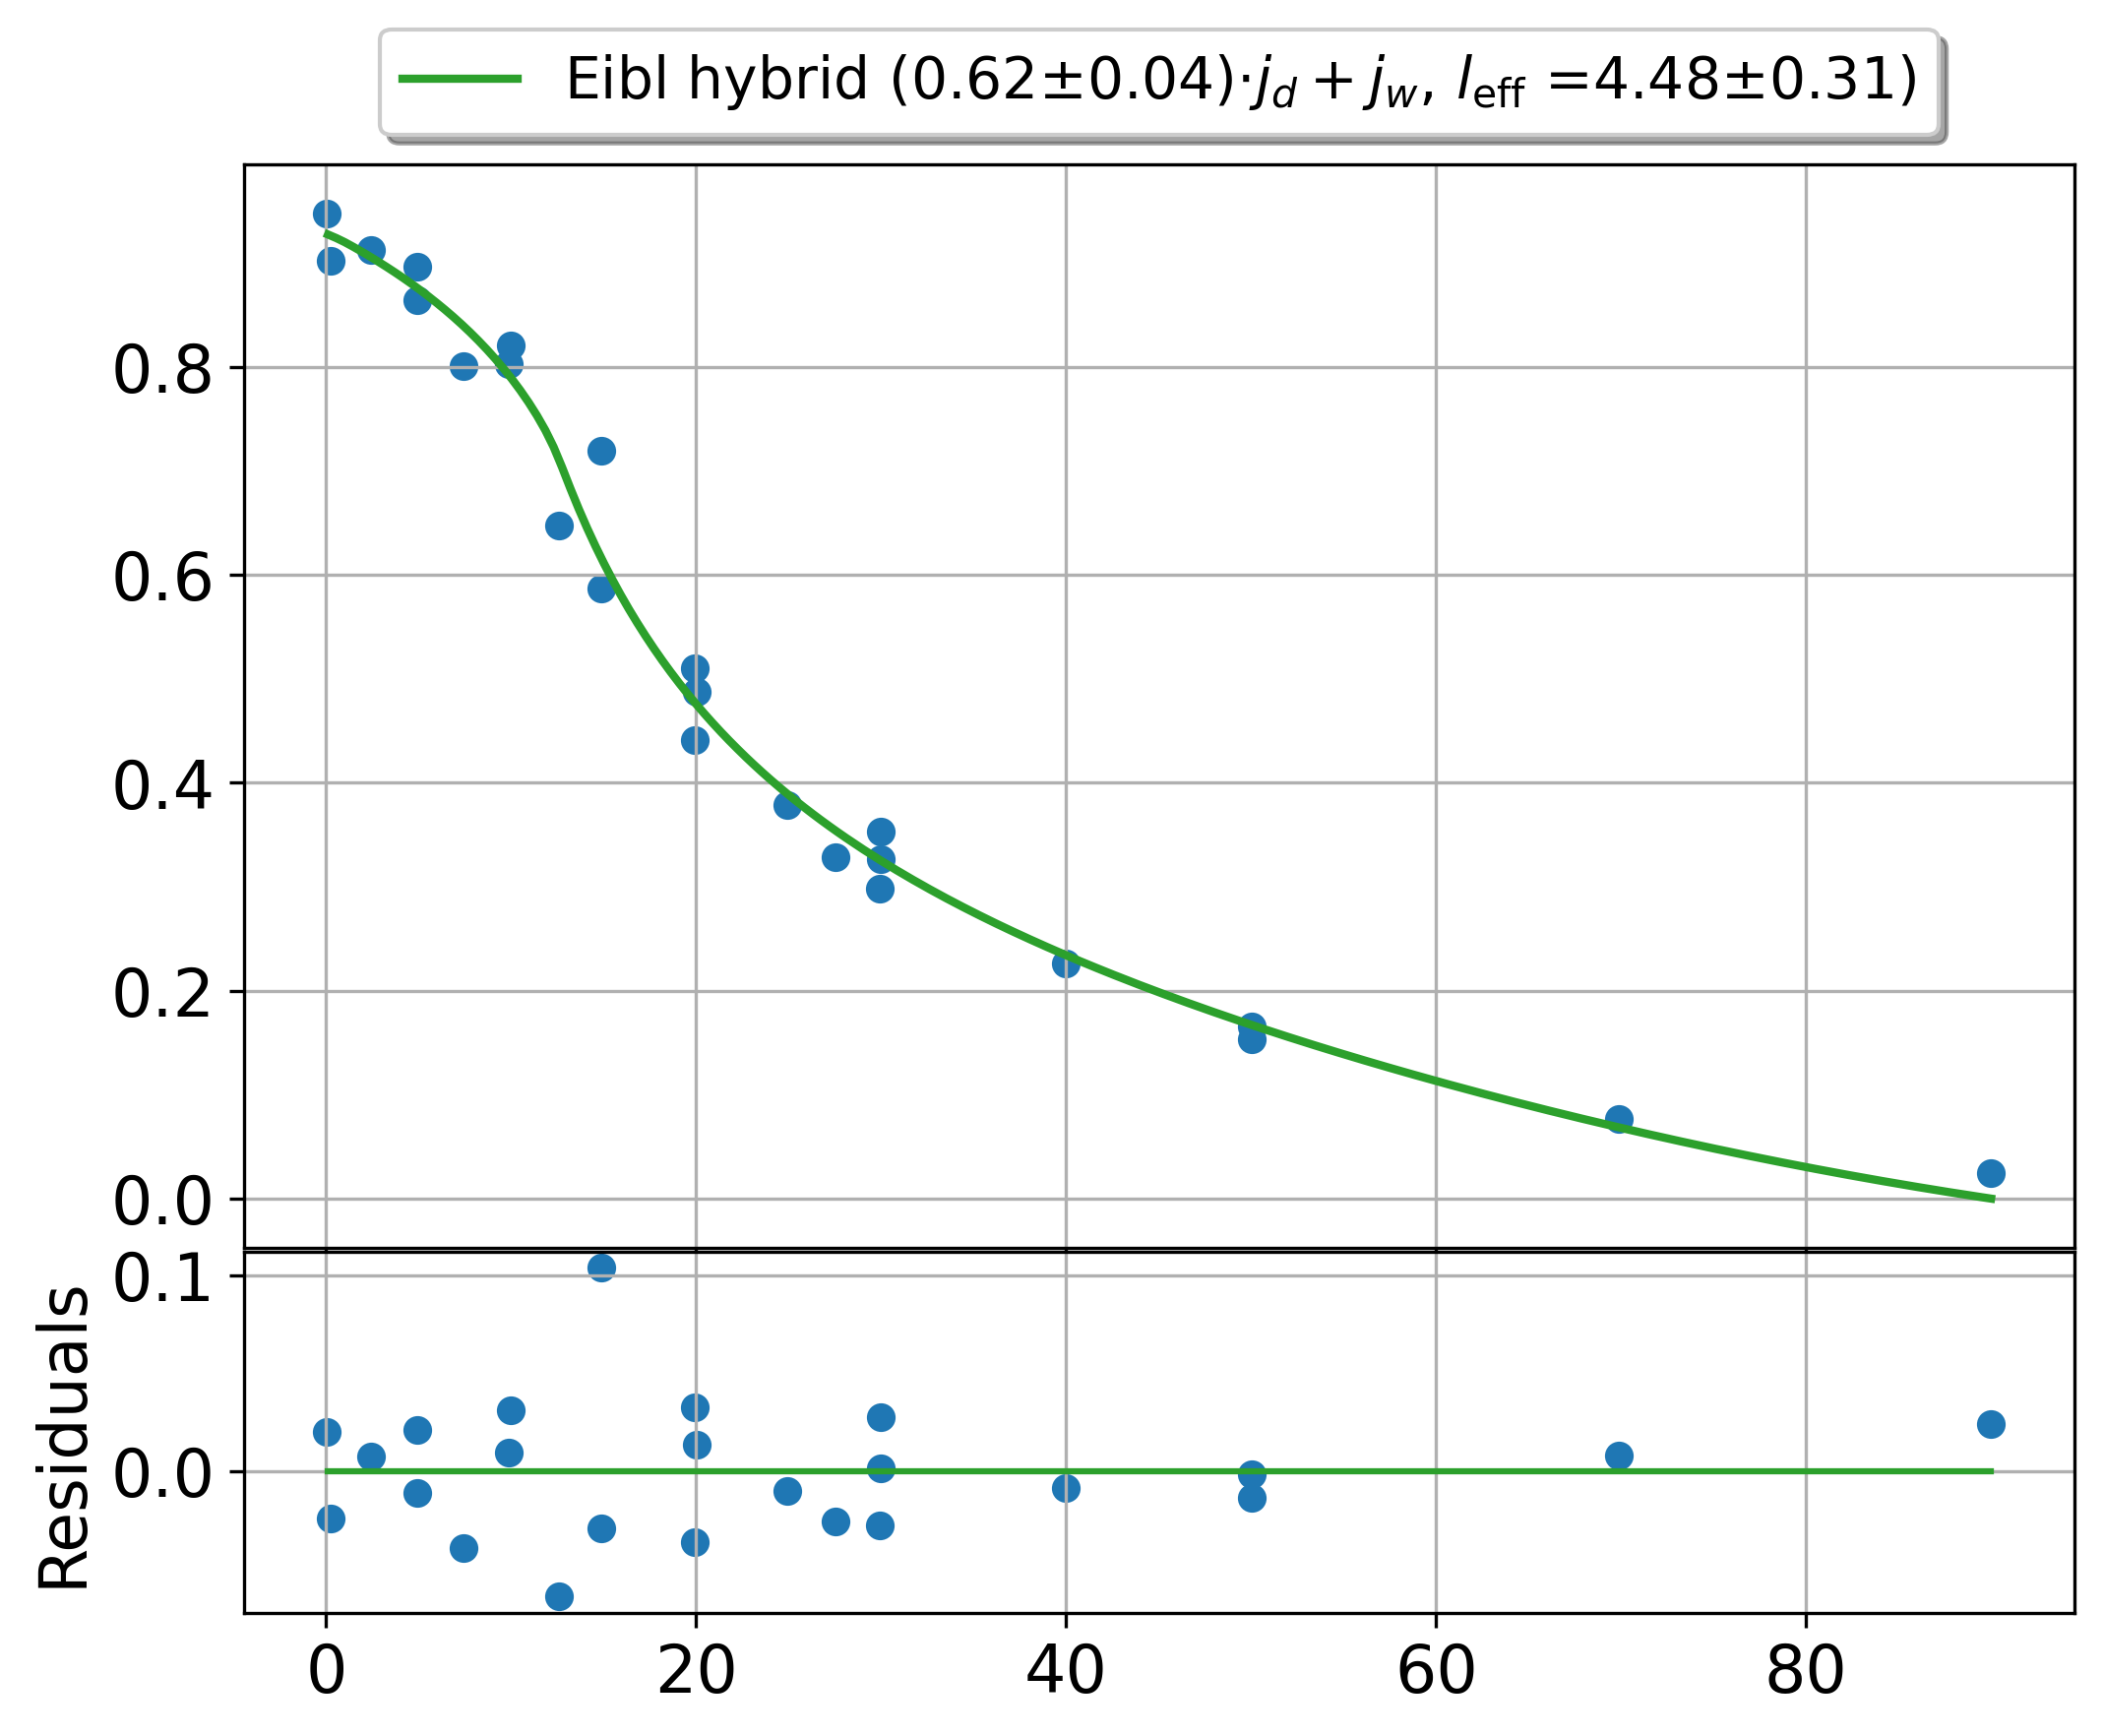

In [168]:
fig = plt.figure(0, figsize=(8,6.5), dpi =300)
ax1=plt.gca()
gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[3, 1]) 
gs.update(#wspace=0.05
        hspace = 0.005
    )

ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])

xs = np.linspace( 0.1,90, 200)
xs_rad = xs * degree
ys_jw_2 = f_fit(xs_rad,*popt_abs)
#print(ys_jw_2)
l_eff_jw, jd_scale, A = popt_abs

ax1.plot(xs,ys_jw_2,
            color = "C2" ,
            label = (r"Eibl hybrid " + f"({jd_scale:.2f}" + r"$\pm$" 
                     +f"{np.sqrt(pcov[1,1]):.2f})"
                     + r"$\cdot j_d + j_w$, $l_{\rm{eff}}$ =" 
                     + f"{l_eff_jw:.2f}"
                     + r"$\pm$" 
                     +f"{np.sqrt(pcov[0,0]):.2f})"),
            lw= 2)

ax1.scatter(data_x,data_y)

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")

#residual subplot:
res_ys = ((data_y - f_fit(data_x*degree, *popt_abs) ))
ax2.scatter(data_x,res_ys,
            label="residuals")
#Plot Fit
ax2.plot(xs, [0.0 for x in xs] , 'C2',
            )

ax2.set_ylabel(r"Residuals")

ax1.set_xlabel(r"$\theta$ [deg]")
ax1.set_ylabel(r"")
ax1.grid(True)

ax1.legend(shadow=True, ncol =1,
            loc='lower center', bbox_to_anchor=(0.5, 1), 
            fontsize = 14
            )
handles, labels = ax1.get_legend_handles_labels()
print(handles, labels)            
plt.tight_layout()
plt.grid(True)